In [2]:
import xarray as xr
# import rioxarray as rio
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, MultiPolygon
import shapely.wkt



In [156]:
# # importando api earth engine
# import ee/home/mapbiomasar/Mayra/OCO2_L4/OCO2_L4/OCO2GriddedXCO2_20180709_v2_1605313492.nc
# # autorização com login 
# ee.Authenticate()
# # iniciando a biblioteca
# ee.Initialize()

In [6]:

# shortcut to clean the crap 

file_name = '/home/mapbiomasar/Mayra/AIRS/CH4_L3_2002_today/AIRS.2021.07.10.L3.RetStd_IR001.v6.0.32.0.G21192211937.hdf'
hdf_file = xr.open_dataset(file_name)


# xco2 = hdf_file[[
#     'xco2', 'time'
# ]]
# xco2 = xco2.to_dataframe()
# xco2 = xco2.dropna()
# xco2 = xco2.reset_index()
# xco2 = xco2[['time','lat','lon','xco2']]
# xco2

ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'h5netcdf', 'scipy', 'cfgrib', 'pynio']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

In [159]:

crs = {'init':'EPSG:4326'}
geometry = [Point(xy) for xy in zip(xco2['lon'], xco2['lat'])]

points = gpd.GeoDataFrame(xco2, 
                          crs = crs, 
                          geometry = geometry)

points


/home/mapbiomasar/miniconda3/envs/geoproc/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,time,lat,lon,xco2,geometry
0,2003-01-16 12:00:00,-47.5,167.5,0.000373,POINT (167.50000 -47.50000)
1,2003-01-16 12:00:00,-42.5,-67.5,0.000374,POINT (-67.50000 -42.50000)
2,2003-01-16 12:00:00,-42.5,172.5,0.000371,POINT (172.50000 -42.50000)
3,2003-01-16 12:00:00,-37.5,-72.5,0.000375,POINT (-72.50000 -37.50000)
4,2003-01-16 12:00:00,-37.5,-67.5,0.000373,POINT (-67.50000 -37.50000)
...,...,...,...,...,...
121861,2020-06-16 00:00:00,72.5,152.5,0.000409,POINT (152.50000 72.50000)
121862,2020-06-16 00:00:00,77.5,-87.5,0.000411,POINT (-87.50000 77.50000)
121863,2020-06-16 00:00:00,77.5,142.5,0.000407,POINT (142.50000 77.50000)
121864,2020-06-16 00:00:00,82.5,-87.5,0.000412,POINT (-87.50000 82.50000)


In [160]:
# filter lat and long

# to avoid excessive processing to shapefiles we define a box
# covering South America


min_lat = -57.5858
max_lat =  15.5988
min_lon = -85.8360
max_lon = -35.8750

# back to original nomenclature
tmp = points.copy()

lat_filter = (tmp["lat"] >= min_lat) & (tmp["lat"] <= max_lat)
lon_filter = (tmp["lon"] >= min_lon) & (tmp["lon"] <= max_lon)

# tmp = tmp.loc[lat_filter & lon_filter]

points = tmp[lat_filter & lon_filter]

In [161]:
# a small subset for testing

points = points[0:1000]

In [162]:

buffers = points.buffer(2.5) #originally 0.5; is that degrees???
bounds = buffers.bounds

bounds['pixel_area'] = bounds.apply(
  lambda obj: Polygon(shell=[
    Point(obj['maxx'],obj['miny']),
    Point(obj['minx'],obj['miny']),
    Point(obj['minx'],obj['maxy']),
    Point(obj['maxx'],obj['maxy']),
    Point(obj['maxx'],obj['miny']),
  ]),
  axis=1
)

# adding indexes to merge dataframes
points.insert(0, 'New_ID', range(1, 1 + len(points)))
bounds.insert(0, 'New_ID', range(1, 1 + len(bounds)))

my_merge = bounds.merge(points, on='New_ID')


/tmp/ipykernel_129826/641316333.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffers = points.buffer(2.5) #originally 0.5; is that degrees???


In [163]:
# my_merge

,New_ID,minx,miny,maxx,maxy,pixel_area,time,lat,lon,xco2,geometry
0,1,-70.0,-45.0,-65.0,-40.0,"POLYGON ((-65 -45, -70 -45, -70 -40, -65 -40, ...",2003-01-16 12:00:00,-42.5,-67.5,0.000374,POINT (-67.50000 -42.50000)
1,2,-75.0,-40.0,-70.0,-35.0,"POLYGON ((-70 -40, -75 -40, -75 -35, -70 -35, ...",2003-01-16 12:00:00,-37.5,-72.5,0.000375,POINT (-72.50000 -37.50000)
2,3,-70.0,-40.0,-65.0,-35.0,"POLYGON ((-65 -40, -70 -40, -70 -35, -65 -35, ...",2003-01-16 12:00:00,-37.5,-67.5,0.000373,POINT (-67.50000 -37.50000)
3,4,-65.0,-40.0,-60.0,-35.0,"POLYGON ((-60 -40, -65 -40, -65 -35, -60 -35, ...",2003-01-16 12:00:00,-37.5,-62.5,0.000374,POINT (-62.50000 -37.50000)
4,5,-60.0,-40.0,-55.0,-35.0,"POLYGON ((-55 -40, -60 -40, -60 -35, -55 -35, ...",2003-01-16 12:00:00,-37.5,-57.5,0.000375,POINT (-57.50000 -37.50000)
...,...,...,...,...,...,...,...,...,...,...,...
995,996,-65.0,-40.0,-60.0,-35.0,"POLYGON ((-60 -40, -65 -40, -65 -35, -60 -35, ...",2005-01-16 12:00:00,-37.5,-62.5,0.000377,POINT (-62.50000 -37.50000)
996,997,-60.0,-40.0,-55.0,-35.0,"POLYGON ((-55 -40, -60 -40, -60 -35, -55 -35, ...",2005-01-16 12:00:00,-37.5,-57.5,0.000377,POINT (-57.50000 -37.50000)
997,998,-75.0,-35.0,-70.0,-30.0,"POLYGON ((-70 -35, -75 -35, -75 -30, -70 -30, ...",2005-01-16 12:00:00,-32.5,-72.5,0.000377,POINT (-72.50000 -32.50000)
998,999,-70.0,-35.0,-65.0,-30.0,"POLYGON ((-65 -35, -70 -35, -70 -30, -65 -30, ...",2005-01-16 12:00:00,-32.5,-67.5,0.000376,POINT (-67.50000 -32.50000)


In [164]:
# new geopandas with the variables of interest
gdf = my_merge.copy()
gdf = gpd.GeoDataFrame(
  gdf,
  crs = crs, 
  geometry = [a for a in gdf['pixel_area']]                               
  )
gdf = gdf.reset_index()
gdf = gdf.loc[:,gdf.columns.isin(['xco2', 'geometry'])]

# print('--> TYPE: ',type(gdf))
gdf


/home/mapbiomasar/miniconda3/envs/geoproc/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,xco2,geometry
0,0.000374,"POLYGON ((-65.00000 -45.00000, -70.00000 -45.0..."
1,0.000375,"POLYGON ((-70.00000 -40.00000, -75.00000 -40.0..."
2,0.000373,"POLYGON ((-65.00000 -40.00000, -70.00000 -40.0..."
3,0.000374,"POLYGON ((-60.00000 -40.00000, -65.00000 -40.0..."
4,0.000375,"POLYGON ((-55.00000 -40.00000, -60.00000 -40.0..."
...,...,...
995,0.000377,"POLYGON ((-60.00000 -40.00000, -65.00000 -40.0..."
996,0.000377,"POLYGON ((-55.00000 -40.00000, -60.00000 -40.0..."
997,0.000377,"POLYGON ((-70.00000 -35.00000, -75.00000 -35.0..."
998,0.000376,"POLYGON ((-65.00000 -35.00000, -70.00000 -35.0..."


/home/mapbiomasar/miniconda3/envs/geoproc/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Text(0.5, 1.0, 'xco2 from Mayra')

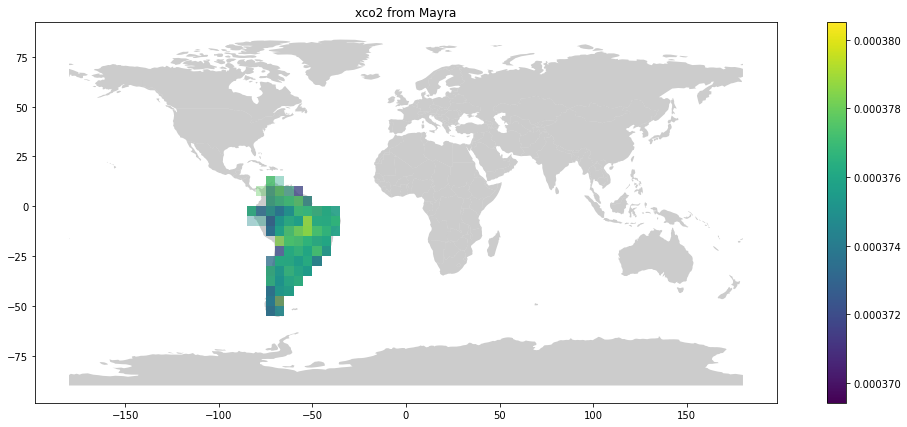

In [165]:
# testing the view

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(18, 7))


# ax.set_xlim(178.0, 181.0)
# ax.set_ylim(20.0, 23.0)
world.plot(ax=ax, alpha=0.4, color='grey')

gpd.GeoDataFrame(
  my_merge,
  crs = crs, 
  geometry = [a for a in my_merge['pixel_area']]                                
  ).plot(column='xco2', ax=ax, legend=True,alpha = 0.4)

# gpd.GeoDataFrame(
#   points,
#   crs = crs, 
#   geometry = [a for a in points['geometry']]                                
#   ).plot(column='xco2', ax=ax)



plt.title('xco2 from Mayra')


In [95]:

gdf = my_merge.copy()
gdf = gpd.GeoDataFrame(
  gdf,
  crs = crs, 
  geometry = [a for a in gdf['pixel_area']]                               
  )
gdf = gdf.reset_index()
gdf = gdf.loc[:,gdf.columns.isin(['xco2', 'geometry'])]

print('--> TYPE: ',type(gdf))
gdf



--> TYPE:  <class 'geopandas.geodataframe.GeoDataFrame'>


/home/mapbiomasar/miniconda3/envs/geoproc/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,xco2,geometry
0,0.000374,"POLYGON ((-65.00000 -45.00000, -70.00000 -45.0..."
1,0.000375,"POLYGON ((-70.00000 -40.00000, -75.00000 -40.0..."
2,0.000373,"POLYGON ((-65.00000 -40.00000, -70.00000 -40.0..."
3,0.000374,"POLYGON ((-60.00000 -40.00000, -65.00000 -40.0..."
4,0.000375,"POLYGON ((-55.00000 -40.00000, -60.00000 -40.0..."
...,...,...
995,0.000377,"POLYGON ((-60.00000 -40.00000, -65.00000 -40.0..."
996,0.000377,"POLYGON ((-55.00000 -40.00000, -60.00000 -40.0..."
997,0.000377,"POLYGON ((-70.00000 -35.00000, -75.00000 -35.0..."
998,0.000376,"POLYGON ((-65.00000 -35.00000, -70.00000 -35.0..."


In [96]:
print('--> ',type(gdf))


gdf.to_file('/home/mapbiomasar/MJT/notebooks/smallGridMerged.shp')


-->  <class 'geopandas.geodataframe.GeoDataFrame'>


/home/mapbiomasar/miniconda3/envs/geoproc/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [107]:
gpd

<module 'geopandas' from '/home/mapbiomasar/miniconda3/envs/geoproc/lib/python3.9/site-packages/geopandas/__init__.py'>

### Part 2: reprocessing and splitting files

TODO: separar os arquivos por meses para subir ao GEE



In [144]:
# summarizing table
print(len(my_merge))
tmp = my_merge.groupby(['lat','lon'])['xco2'].mean()
len(tmp)

11275


147

In [141]:
tmp.reset_index()


,lat,lon,xco2
0,-57.5,-77.5,0.000402
1,-57.5,-72.5,0.000402
2,-57.5,-67.5,0.000403
3,-57.5,-62.5,0.000403
4,-57.5,-57.5,0.000404
...,...,...,...
142,12.5,-57.5,0.000400
143,12.5,-52.5,0.000400
144,12.5,-47.5,0.000400
145,12.5,-42.5,0.000402
